In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

scaler = StandardScaler()
train = pd.read_csv('/gdrive/My Drive/Data/train1.csv')
test = pd.read_csv('/gdrive/My Drive/Data/test1.csv')
sample_sub = pd.read_csv('/gdrive/My Drive/Data/sample_submission1.csv')
df = pd.concat([train,test],axis=0,sort=False)
df.drop(['X14','X16','X19'],axis=1, inplace=True)
for col in df.columns:
  col_type = df[col].dtypes
  if str(col_type)[:3] == 'int':
    df[col] = df[col].astype(np.int16)
  else:
    df[col] = df[col].astype(np.float32)
sc_col = df.columns[1:38]
not_col = df.columns.difference(sc_col)
df_sc = scaler.fit_transform(df[sc_col])
df_sc = pd.DataFrame(df_sc,columns=sc_col ,index=df.index)
df = pd.concat([df_sc,df[not_col]],axis=1,sort=False)
df['hour'] = np.repeat((np.arange(0,df.shape[0]/6,dtype=np.int16)%24),6)
train = df.iloc[:train.shape[0],:].drop('id',axis=1)
test = df.iloc[train.shape[0]:,:].drop('id',axis=1)
train.shape

(4752, 57)

In [17]:
train1 = train.iloc[:4320,:]
train2 = train.loc[4320:,:]
col = train1.columns[37:55]
train1.drop('Y18',axis=1, inplace=True)
train2.drop(col,axis=1, inplace=True)
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4320 entries, 0 to 4319
Data columns (total 56 columns):
X00     4320 non-null float32
X01     4320 non-null float32
X02     4320 non-null float32
X03     4320 non-null float32
X04     4320 non-null float32
X05     4320 non-null float32
X06     4320 non-null float32
X07     4320 non-null float32
X08     4320 non-null float32
X09     4320 non-null float32
X10     4320 non-null float32
X11     4320 non-null float32
X12     4320 non-null float32
X13     4320 non-null float32
X15     4320 non-null float32
X17     4320 non-null float32
X18     4320 non-null float32
X20     4320 non-null float32
X21     4320 non-null float32
X22     4320 non-null float32
X23     4320 non-null float32
X24     4320 non-null float32
X25     4320 non-null float32
X26     4320 non-null float32
X27     4320 non-null float32
X28     4320 non-null float32
X29     4320 non-null float32
X30     4320 non-null float32
X31     4320 non-null float32
X32     4320 non-null f

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [3]:
y_col = train1.columns[37:55]
x_col = train1.columns.difference(y_col)
x_col

Index(['X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X22',
       'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32',
       'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'hour'],
      dtype='object')

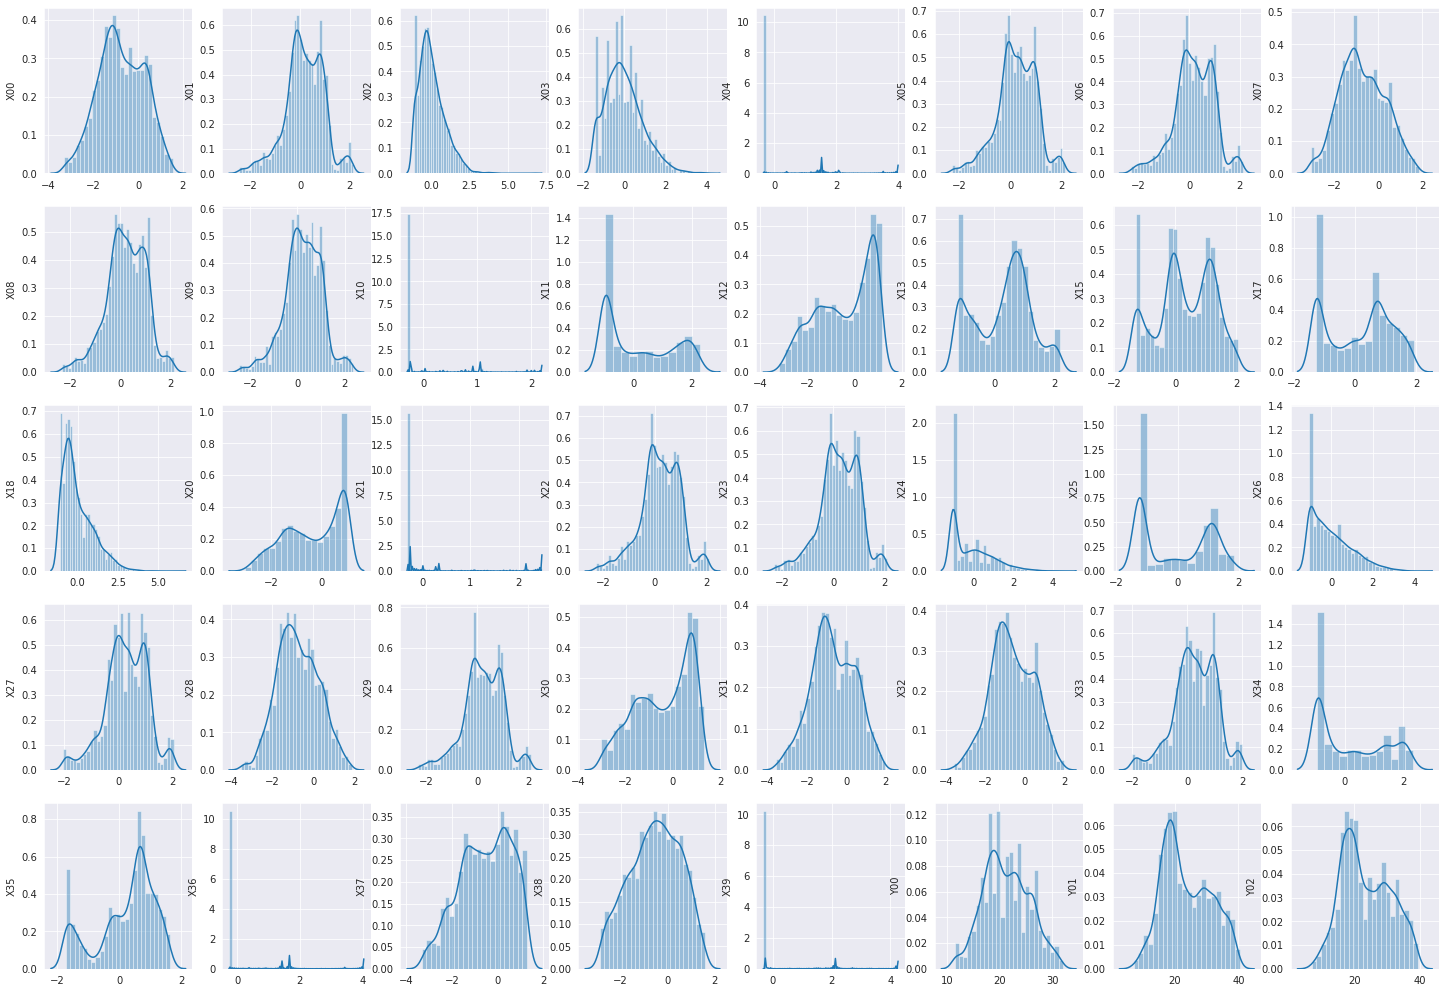

In [93]:
sns.set_style("darkgrid")
plt.figure(figsize=(25,25))
for i, col in enumerate(train.columns[:40]):
    plt.subplot(7,8,i+1)
    sns.distplot(train[col])
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

In [0]:
x_col

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
          20,    21,    22,    23, 'X00', 'X01', 'X02', 'X03', 'X04', 'X05',
       'X06', 'X07', 'X08', 'X09', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17',
       'X18', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28',
       'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38',
       'X39'],
      dtype='object')

In [11]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.utils import get_custom_objects
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, BatchNormalization
from keras import optimizers

train_reshaped = np.expand_dims(train1[x_col],axis=1)
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(1,38),activation='mish' ))
# model.add(LSTM(50, return_sequences= False,activation='relu',))
model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences= False,activation='mish',))
model.add(Dense(100,activation='mish'))
model.add(Dropout(0.1))
model.add(Dense(50,activation='mish'))
model.add(Dense(18,activation='linear'))
adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 150)            113400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 18)               

In [0]:

class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [47]:
model.fit(train_reshaped,train1[y_col],batch_size=12, epochs=1,validation_split=0.25)

Train on 3240 samples, validate on 1080 samples
Epoch 1/1
3240/3240 [==============================] - 3s 961us/step - loss: 2.8878 - val_loss: 3.7308


In [7]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
plt.figure(figsize = (13,8))
class LRFinder(Callback):
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.total_iterations = steps_per_epoch * epochs
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

<Figure size 936x576 with 0 Axes>

In [12]:
epochs = 200
batch_size = 30
epoch_size = train1.shape[0]

early_stop = keras.callbacks.EarlyStopping(patience=200, monitor='val_loss')

ckpt_dir = '/gdrive/My Drive/ckpt1'
ckpt_path = ckpt_dir + '/model1_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
model.fit(train_reshaped,train1[y_col],batch_size=30, epochs=200,validation_split=0.05,callbacks=[ckpt,lr_finder,early_stop])

Train on 4104 samples, validate on 216 samples
Epoch 1/200
4104/4104 [==============================] - 3s 811us/step - loss: 599.9399 - val_loss: 619.2493
Epoch 2/200
4104/4104 [==============================] - 2s 458us/step - loss: 599.3503 - val_loss: 618.2921
Epoch 3/200
4104/4104 [==============================] - 2s 435us/step - loss: 597.4646 - val_loss: 614.4631
Epoch 4/200
4104/4104 [==============================] - 2s 449us/step - loss: 582.0797 - val_loss: 578.4637
Epoch 5/200
4104/4104 [==============================] - 2s 411us/step - loss: 431.6838 - val_loss: 348.3883
Epoch 6/200
4104/4104 [==============================] - 2s 440us/step - loss: 260.7004 - val_loss: 245.1240
Epoch 7/200
4104/4104 [==============================] - 2s 439us/step - loss: 204.0909 - val_loss: 190.5580
Epoch 8/200
4104/4104 [==============================] - 2s 467us/step - loss: 162.9256 - val_loss: 154.4835
Epoch 9/200
4104/4104 [==============================] - 2s 462us/step - loss: 12

In [18]:
model.load_weights('/gdrive/My Drive/ckpt1/model1_29_valloss3.41.hdf5')
y18 = train2["Y18"]
train2_x = train2.drop("Y18",axis=1)
y017 = model.predict(np.expand_dims(train2_x,axis=1))
y017 = pd.DataFrame(y017,columns=y_col)
y017.head()

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
0,14.158936,13.693209,12.599590,15.924563,16.264456,11.735675,14.278422,14.945756,12.837403,11.869825,12.022115,12.712914,13.497280,12.248851,12.299643,13.038947,12.594373,13.311428
1,15.749345,15.261840,14.205558,17.833061,18.266373,13.338027,16.003542,16.668863,14.380928,13.401033,13.519992,14.231006,15.270432,13.660456,13.605683,14.590309,14.288358,14.933342
2,14.327068,13.831241,12.760507,16.157589,16.506432,11.879991,14.402646,15.074968,12.952653,11.991529,12.107415,12.808444,13.648146,12.373006,12.428051,13.186956,12.760210,13.426231
3,17.260912,16.692730,15.815720,19.819977,20.306803,14.991958,17.454447,18.128628,15.776456,14.783400,14.833273,15.487704,16.900278,14.973409,14.790759,15.970722,15.914556,16.309240
4,17.266005,16.691694,15.819420,19.832848,20.318928,14.995484,17.445604,18.120350,15.771255,14.775823,14.823027,15.473264,16.894697,14.972072,14.791333,15.970215,15.913905,16.298464


In [21]:
y_train = pd.concat([train1[y_col],y017],axis=0,sort=False)
y_train.shape

(4752, 18)

In [22]:
model1 = Sequential()
model1.add(LSTM(50, return_sequences=True, input_shape=(1,18),activation='mish' ))
# model.add(LSTM(50, return_sequences= False,activation='relu',))
model1.add(LSTM(30, return_sequences= False,activation='mish',))
model1.add(Dense(15,activation='mish'))
model1.add(Dense(1,activation='linear'))
adam = optimizers.Adam(lr=0.0005)

model1.compile(optimizer=adam, loss='mse')
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 50)             13800     
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_9 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 16        
Total params: 24,001
Trainable params: 24,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
ckpt_dir = '/gdrive/My Drive/ckpt2'
ckpt_path = ckpt_dir + '/model2_{epoch:02d}_valloss{loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
model1.fit(np.expand_dims(y017,axis=1),y18,batch_size=30, epochs=200,callbacks=[lr_finder,early_stop,ckpt])

Epoch 1/200
432/432 [==============================] - 0s 263us/step - loss: 546.4796


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/200
432/432 [==============================] - 0s 234us/step - loss: 145.2526
Epoch 3/200
432/432 [==============================] - 0s 201us/step - loss: 15.6693
Epoch 4/200
432/432 [==============================] - 0s 237us/step - loss: 10.1037
Epoch 5/200
432/432 [==============================] - 0s 238us/step - loss: 8.3302
Epoch 6/200
432/432 [==============================] - 0s 244us/step - loss: 8.0990
Epoch 7/200
432/432 [==============================] - 0s 257us/step - loss: 8.0655
Epoch 8/200
432/432 [==============================] - 0s 234us/step - loss: 7.8387
Epoch 9/200
432/432 [==============================] - 0s 261us/step - loss: 7.7195
Epoch 10/200
432/432 [==============================] - 0s 243us/step - loss: 7.5094
Epoch 11/200
432/432 [==============================] - 0s 228us/step - loss: 7.4894
Epoch 12/200
432/432 [==============================] - 0s 246us/step - loss: 7.2369
Epoch 13/200
432/432 [==============================] - 0s 248us/step

KeyboardInterrupt: ignored

In [0]:
test = test.dropna(axis=1)
# yt017 = model.predict()

In [51]:
train2.corr()


,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y18,hour
X00,1.000000,-0.696720,0.440166,0.300344,NaN,-0.730695,-0.701124,0.944908,-0.777789,-0.785817,-0.076724,0.594476,-0.886610,0.173283,-0.021463,0.303033,0.692302,-0.967237,-0.068537,-0.706988,-0.727793,0.778122,0.581917,0.621905,-0.678161,0.924128,-0.694877,-0.884103,0.937889,0.924167,-0.695748,0.612575,0.205820,NaN,-0.943287,-0.902065,0.102556,0.847230,0.538593
X01,-0.696720,1.000000,-0.447365,-0.294557,NaN,0.961756,0.982726,-0.682473,0.972826,0.987940,0.175013,-0.523687,0.621786,-0.118405,-0.264896,-0.349187,-0.493382,0.656779,0.158382,0.965681,0.973770,-0.502816,-0.348428,-0.527947,0.970266,-0.670913,0.975725,0.615949,-0.649316,-0.612120,0.970067,-0.562285,-0.048601,NaN,0.696238,0.642507,-0.093939,-0.469846,-0.368268
X02,0.440166,-0.447365,1.000000,0.206428,NaN,-0.479808,-0.471977,0.435400,-0.483359,-0.456900,0.074002,0.340910,-0.334254,0.085013,0.195446,0.159972,0.363650,-0.424916,0.107573,-0.472819,-0.476762,0.328928,0.274054,0.309952,-0.462472,0.459094,-0.469067,-0.383353,0.351383,0.392272,-0.468204,0.343533,-0.011653,NaN,-0.443812,-0.443446,0.210160,0.346297,0.254406
X03,0.300344,-0.294557,0.206428,1.000000,NaN,-0.299973,-0.318951,0.303423,-0.326369,-0.308741,-0.021169,0.247194,-0.266408,0.059514,0.083216,0.125422,0.235622,-0.284736,0.001721,-0.295444,-0.324300,0.204122,0.200558,0.308729,-0.314707,0.275629,-0.320286,-0.287687,0.280043,0.284122,-0.318467,0.266386,0.012769,NaN,-0.299352,-0.295032,0.035041,0.234911,0.236408
X04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X05,-0.730695,0.961756,-0.479808,-0.299973,NaN,1.000000,0.964957,-0.729163,0.957938,0.954025,0.012442,-0.626618,0.591310,-0.127396,-0.192379,-0.357919,-0.479952,0.647315,-0.020808,0.998932,0.986579,-0.518316,-0.391944,-0.582313,0.972912,-0.772202,0.984826,0.595847,-0.637963,-0.625722,0.974671,-0.639190,-0.015809,NaN,0.728059,0.752784,-0.308303,-0.484977,-0.469972
X06,-0.701124,0.982726,-0.471977,-0.318951,NaN,0.964957,1.000000,-0.695749,0.989530,0.972398,0.153129,-0.511806,0.621290,-0.114372,-0.260130,-0.341382,-0.510769,0.649411,0.117818,0.968341,0.985148,-0.500333,-0.337355,-0.547430,0.982268,-0.685835,0.986983,0.631506,-0.645177,-0.623382,0.981708,-0.546013,-0.004143,NaN,0.712982,0.671160,-0.130987,-0.502424,-0.356921
X07,0.944908,-0.682473,0.435400,0.303423,NaN,-0.729163,-0.695749,1.000000,-0.780651,-0.770639,-0.121321,0.636673,-0.882022,0.140170,-0.062547,0.294954,0.680648,-0.880499,-0.076489,-0.703712,-0.736905,0.780890,0.629398,0.604215,-0.651435,0.946606,-0.699867,-0.910036,0.933640,0.962667,-0.668008,0.652966,0.223357,NaN,-0.983196,-0.907242,0.131228,0.832904,0.559231
X08,-0.777789,0.972826,-0.483359,-0.326369,NaN,0.957938,0.989530,-0.780651,1.000000,0.981654,0.176397,-0.537093,0.707189,-0.118348,-0.222171,-0.347877,-0.575868,0.729979,0.138431,0.956261,0.979003,-0.578109,-0.406942,-0.579734,0.961742,-0.757081,0.973818,0.725394,-0.733466,-0.724026,0.964326,-0.572675,-0.046709,NaN,0.795950,0.735540,-0.107421,-0.592733,-0.390949
X09,-0.785817,0.987940,-0.456900,-0.308741,NaN,0.954025,0.972398,-0.770639,0.981654,1.000000,0.194605,-0.539445,0.727043,-0.131345,-0.224049,-0.354446,-0.573077,0.750071,0.177422,0.952875,0.967838,-0.585660,-0.408832,-0.573357,0.952848,-0.744390,0.962373,0.713069,-0.755199,-0.713077,0.956109,-0.579262,-0.081204,NaN,0.783023,0.714861,-0.064060,-0.575147,-0.399116


In [0]:
model1.load_weights('/gdrive/My Drive/ckpt2/model2_58_valloss2.75.hdf5')
yt017 = model.predict(np.expand_dims(test,axis=1))
# yt017 = scaler1.transform(yt017)
yt18 = model1.predict(yt017.reshape(yt017.shape[0],1,yt017.shape[1]))

In [27]:
pd.DataFrame(yt18).describe()

,0
count,11520.000000
mean,23.617947
std,7.363092
min,0.152712
25%,19.871139
50%,23.055140
75%,28.679255
max,37.981045


In [0]:
sample_sub["Y18"] = yt18
sample_sub.to_csv('/gdrive/My Drive/Data/sample2.csv',index=False)

In [0]:
sample_sub

,id,Y18
0,4752,20.076042
1,4753,20.091465
2,4754,19.861282
3,4755,19.765711
4,4756,19.762352
...,...,...
11515,16267,25.866146
11516,16268,26.781103
11517,16269,26.660933
11518,16270,26.722603


In [0]:
y18.describe()

count    432.000000
mean      26.687500
std        6.286621
min       18.500000
25%       21.000000
50%       25.000000
75%       31.500000
max       41.500000
Name: Y18, dtype: float64